# Practice Session 07: Connected components

*Introduction to Network Science* (2025/26), UPF

***Version 1***

In this session we will learn how to use [`networkx`](https://networkx.github.io/) to analyze connected components of a graph. 

We will use the [Star Wars graph](https://github.com/evelinag/StarWars-social-network/tree/master/networks). The dataset is contained in this input file that you will find in our [data](https://github.com/chatox/networks-science-course/tree/master/practicum/data) directory:
* ``starwars.graphml``: co-occurence of characters in scenes in the Star Wars saga in [GraphML](http://graphml.graphdrawing.org/) format.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics

# 1. The Star Wars graph

The following code just loads the *Star Wars* graph into variable `g`.

***Do not change the `INPUT_GRAPH_FILENAME` below!** Instead, place the file appropriately in the same directory and make sure you submit it in the zip file along with the notebook. It will be considered a mistake otherwise.*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [5]:
# LEAVE AS-IS

INPUT_GRAPH_FILENAME = "data/starwars/starwars.graphml"

# Read the graph in GraphML format
g_in = nx.read_graphml(INPUT_GRAPH_FILENAME)

# Re-label the nodes so they use the 'name' as label
g_relabeled = nx.relabel.relabel_nodes(g_in, dict(g_in.nodes(data='name')))

# Convert the graph to undirected
g = g_relabeled.to_undirected()

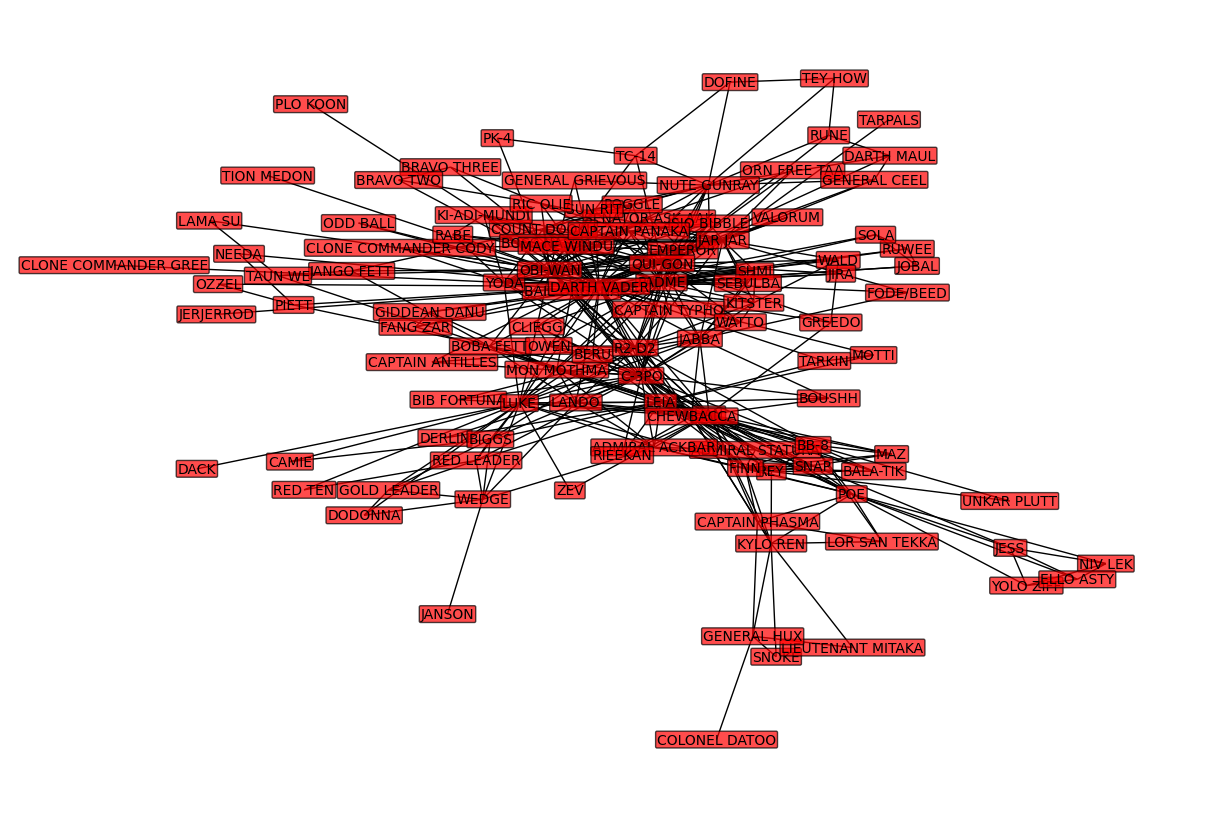

In [6]:
# LEAVE AS-IS (or modify slightly if you want) — we will reuse this function

def plot_graph(g):

    # Create a figure
    plt.figure(figsize=(12,8))

    # Layout the nodes using a spring model
    nx.draw_spring(
        g, 
        with_labels=True, font_size=10,     # Make labels, with label box defined below
        bbox=dict(facecolor="red", edgecolor='black', boxstyle='round,pad=0.1', alpha=0.7),
        node_size=0     # Hide nodes, leave only labels
    )

    # Display
    plt.show()

plot_graph(g)

This is in fact a connected graph because I can't see any nodes that are singletons, meaning there is a path between every pair of nodes.

In [7]:
print(nx.is_connected(g))

True


In [10]:
max_degree = max(dict(g.degree()).values())
avg_degree = statistics.mean(dict(g.degree()).values())
standard_dev_degree = statistics.stdev(dict(g.degree()).values())

print(f"Max degree: {max_degree}")
print(f"Mean degree: {round(avg_degree, 1):.2f}")
print(f"Standard deviation of degree: {round(standard_dev_degree, 1):.2f}")

Max degree: 52
Mean degree: 8.10
Standard deviation of degree: 8.70


This is not a scale-free network. Although the max degree (52) is considerably higher than the mean degree (8.1), the sd (8.7) is only slightly more than the mean which tells us that the network isn't particularly skewed towards hubs as would be the case in a scale-free network. An er network with the same average degree would have an expected sd of about sqrt(8.1) which is about 2.9, which is way lower than out observed sd but I don't think its enough to make it a hub-dominated scale-free network.

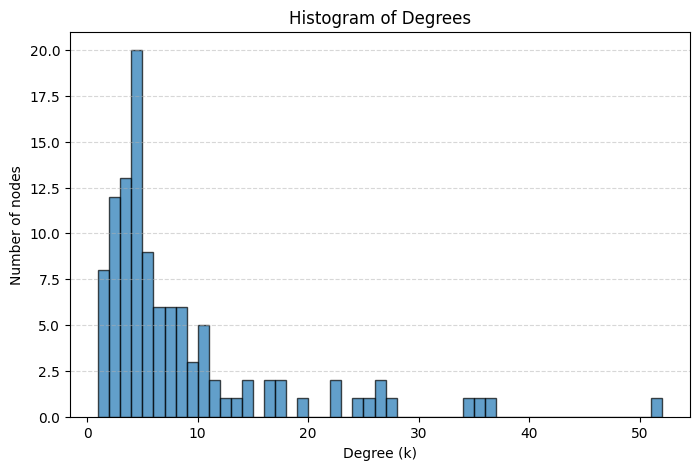

In [14]:
import matplotlib.pyplot as plt

degrees = [degree for node, degree in g.degree()] # get list of degrees

bin_width = 1 # found that 1 works just dine for this data
bins = range(min(degrees), max(degrees) + bin_width, bin_width) # make bins

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes")
plt.title("Histogram of Degrees")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# 2. Remove a fraction of edges

The following function `remove_edges_uniformly_at_random(g, p)` returns a new graph which is a copy of `g` in which a fraction `p` of edges have been removed (with uniform probability). Leave it as-is, we will use it below.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [15]:
# LEAVE AS-IS

def remove_edges_uniformly_at_random(g_in, p):
    # Check input is within bounds
    if p < 0.0 or p > 1.0:
        raise ValueError

    # Create a copy of the input graph
    g_out = g_in.copy()

    # Decide how many edges should be in the output graph
    target_num_edges = int((1.0-p) * g_in.number_of_edges())

    # While there are more edges than desired
    while g_out.number_of_edges() > target_num_edges:

        # Remove one random edge
        edge = random.choice(list(g_out.edges()))

        if g_out.has_edge(edge[0], edge[1]):
            g_out.remove_edge(edge[0], edge[1])

    # Return the resulting graph
    return g_out

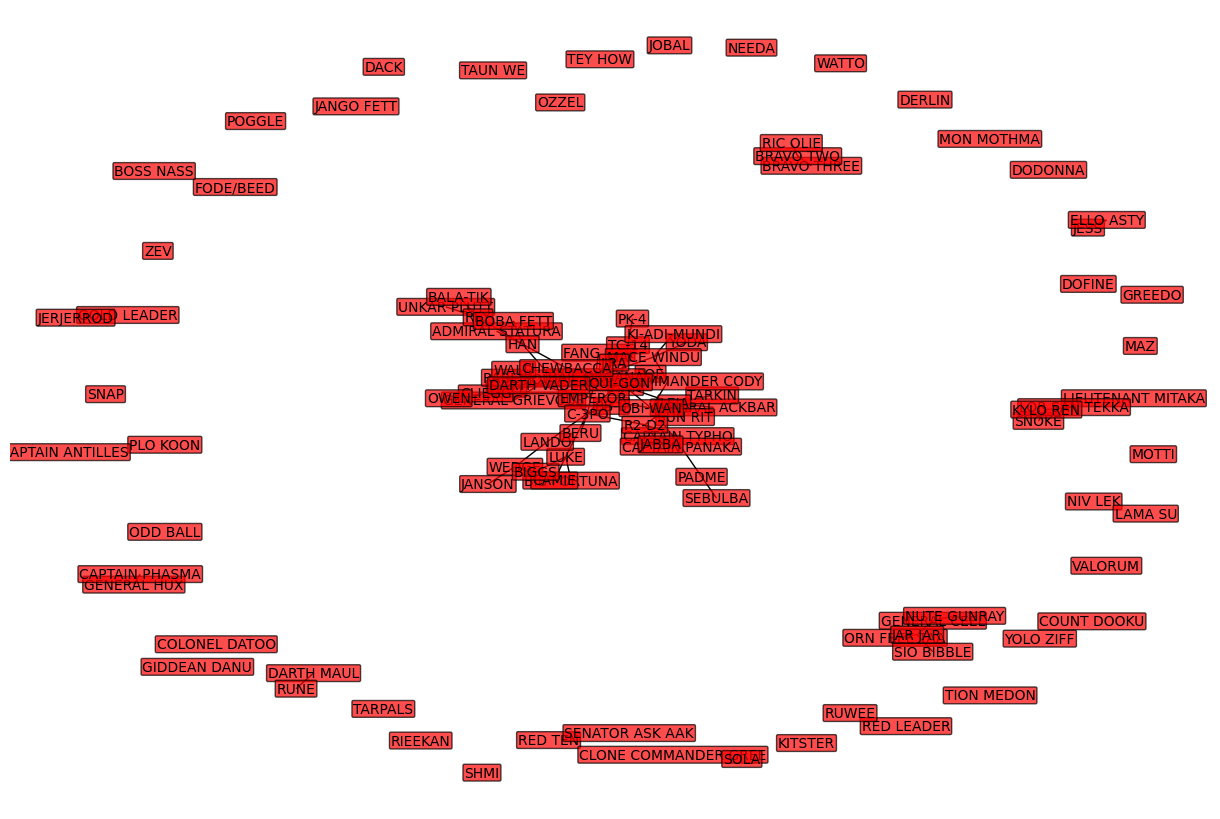

In [19]:
g15 = remove_edges_uniformly_at_random(g, 0.85)
plot_graph(g15)

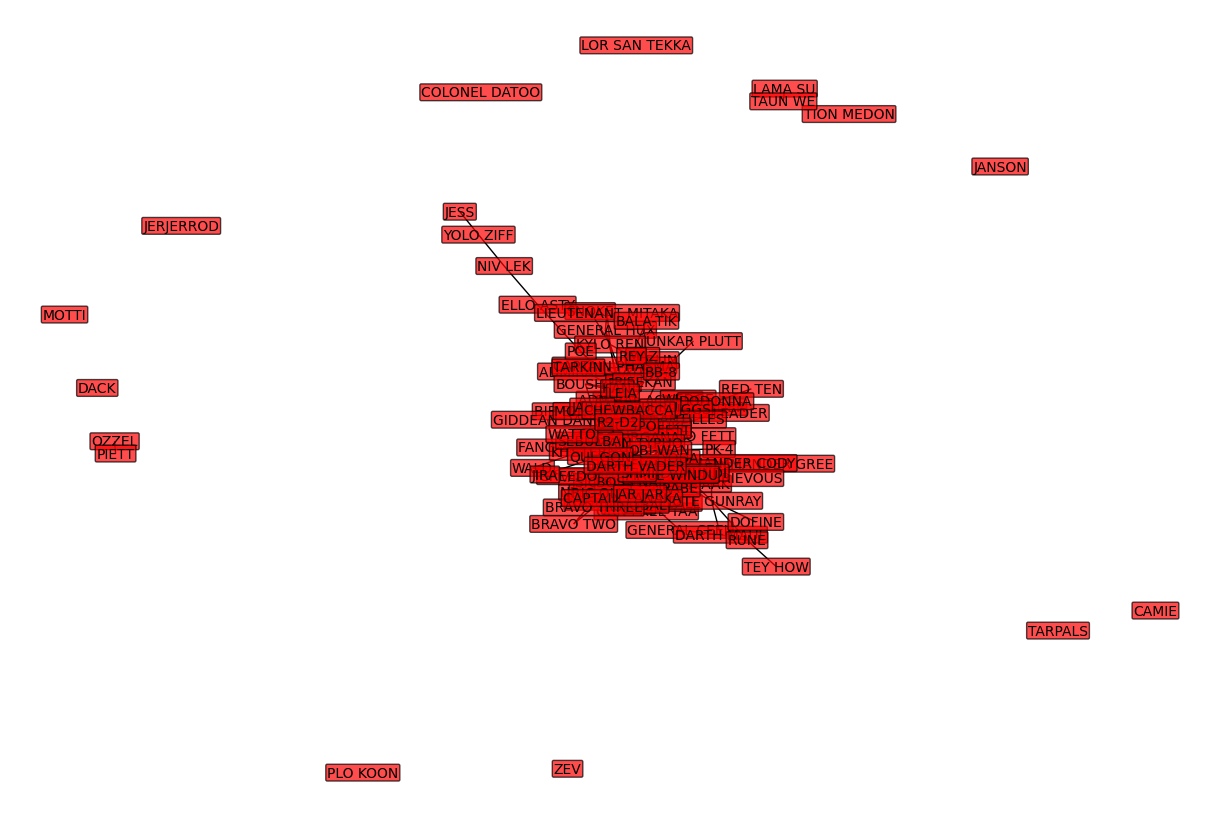

In [20]:
g50 = remove_edges_uniformly_at_random(g, 0.50)
plot_graph(g50)

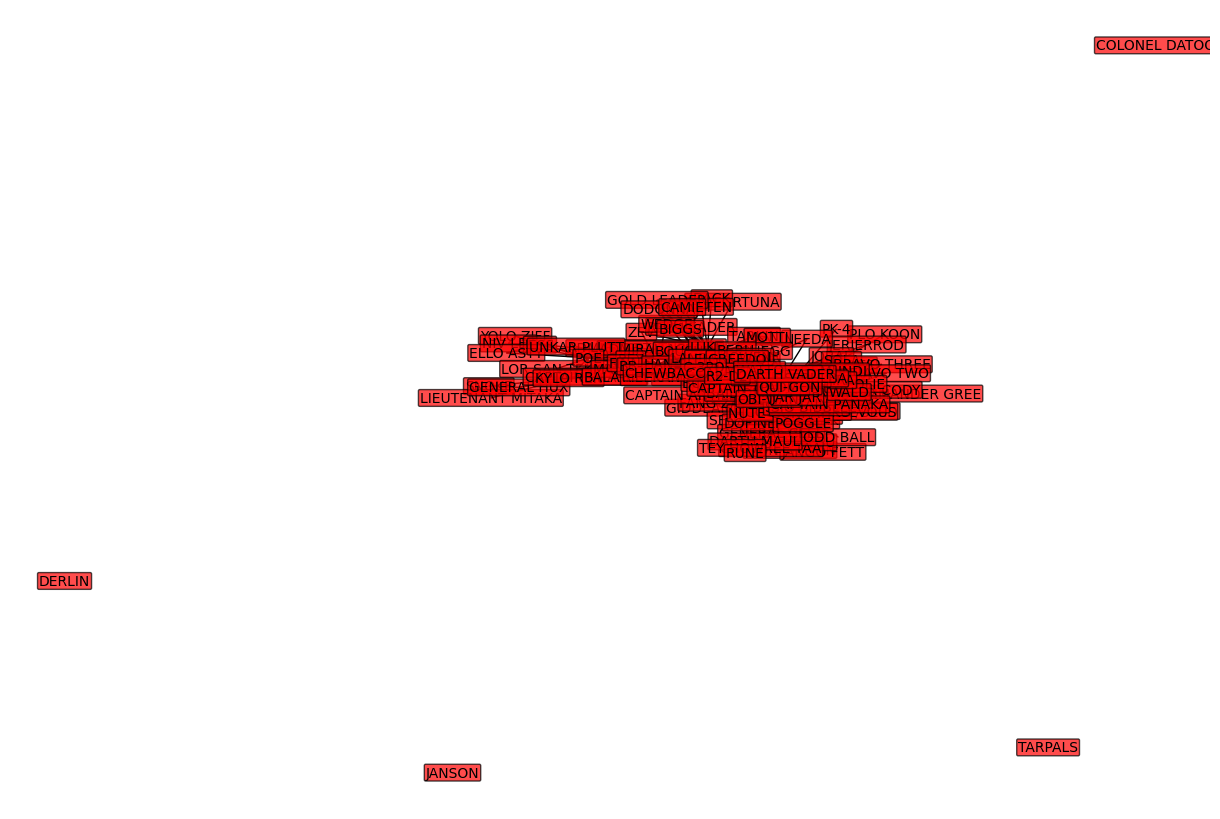

In [21]:
g85 = remove_edges_uniformly_at_random(g, 0.15)
plot_graph(g85)

1. The number of connected components is obviously increasing, since we are removing edges and therefore paths between nodes. And it can be easily observed in the graphs, where as we remove edges we start to accumulate a ring of solitary nodes that now make up their own connected component.

2. The size of the largest connected component is decreasing, and this is something that follows from the previous answer. If a certain graph has a largest connected component with a certain size and then we remove edges from that network, there only exists the opportunity that this connected component either stays the same in size or is reduced, since removing an edge can remove paths.

It kinda looks like we start go get a hub structure as we remove nodes but thats just how nx decides to place the singletons. In reality we just start to get an increasing amount of singletons surrounding one relatively large component in the middle.

In [22]:
# LEAVE AS-IS

def remove_edges_by_betweenness(g_in, p):
    # Check input is within bounds
    if p < 0.0 or p > 1.0:
        raise ValueError

    # Create a copy of the input graph
    g_out = g_in.copy()

    # Compute edge betweenness
    edge_betweenness = nx.edge_betweenness_centrality(g_out)
    edges_by_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)

    # Decide how many edges should be in the output graph
    target_num_edges = int((1.0-p) * g_in.number_of_edges())

    # While there are more edges than desired
    while g_out.number_of_edges() > target_num_edges:
        edge_to_remove, betweenness = edges_by_betweenness.pop(0)
        g_out.remove_edge(*edge_to_remove)

    # Return the resulting graph
    return g_out

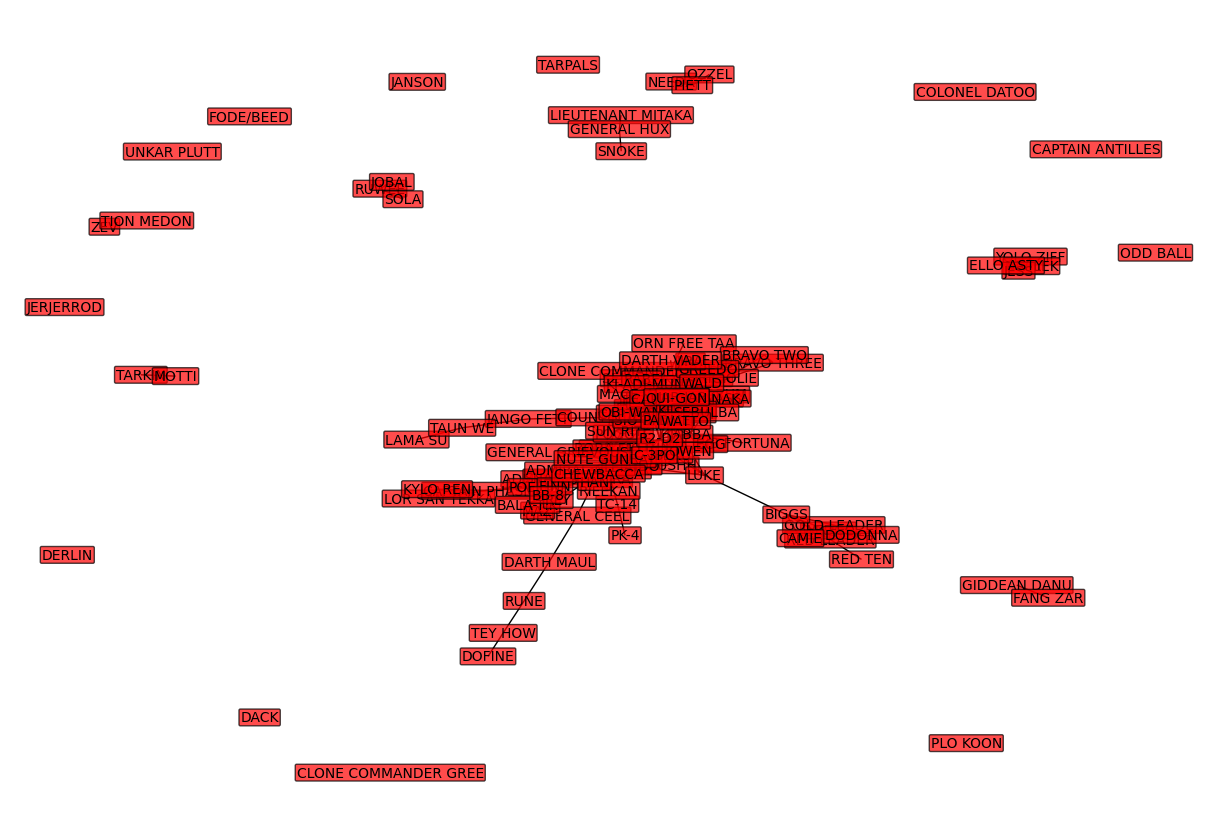

In [23]:
# LEAVE AS-IS

g50b = remove_edges_by_betweenness(g, 0.50)
plot_graph(g50b)

As expected, prioritizing the removal of edges with higher betweeness (meaning higher importance in terms of paths between nodes) broke the network into more connected components than just removing the edges randomly. This makes sense because betweeness is precisely a score of how many pairs of nodes rely (completely or partially) on that edge to be connected.

# 3. Assigning connected components

In [28]:
def assign_components(g):
    node2componentid = {}
    componentid = 1
    for node in g.nodes():
        if node not in node2componentid:
            assign_component_recursive(g, node2componentid, node, componentid)
            componentid += 1
    return node2componentid

def assign_component_recursive(g, node2componentid, starting_node, componentid):
    node2componentid[starting_node] = componentid
    for neighbor in g.neighbors(starting_node):
        if neighbor not in node2componentid:
            assign_component_recursive(g, node2componentid, neighbor, componentid)

In [29]:
# LEAVE AS-IS

# Test on cycle graph
cycle_components = assign_components(nx.cycle_graph(10))
for componentid in cycle_components.values():
    assert componentid == 1, "All nodes in cycle graph should belong to the same component, with ID 1."

# Test on caveman graph
caveman_components = assign_components(nx.caveman_graph(3, 3))
for componentid in caveman_components.values():
    assert componentid in [1, 2, 3], "Nodes in caveman graph should belong to one of three components (1, 2, or 3)."
    assert len([n for n, c in caveman_components.items() if c == componentid]) == 3, "There should be exactly 3 nodes assigned to each component in the caveman graph."

In [30]:
# LEAVE AS-IS

# Get component assignments of nodes using the function just defined
components_g50b = assign_components(g50b)

# Print component assignments
for character in ['LUKE', 'KYLO REN', 'SNOKE', 'PLO KOON'] :
    print(f"Character {character:<8} belongs to component {components_g50b[character]}")

Character LUKE     belongs to component 3
Character KYLO REN belongs to component 3
Character SNOKE    belongs to component 4
Character PLO KOON belongs to component 12


# 4. Number of connected components

In [34]:
def extract_connected_component_sizes(g):
    component_sizes = {} # create dict
    node2componentid = assign_components(g) # node -> component mapping
    for node, comp_id in node2componentid.items(): # count nodes per component
        if comp_id not in component_sizes:
            component_sizes[comp_id] = 0
        component_sizes[comp_id] += 1
    return component_sizes

component_sizes_g50b = extract_connected_component_sizes(g50b)

components_greater_than_1 = []
for comp_id, size in component_sizes_g50b.items(): # iterate through rows in component_sizes_g50b 
    if size > 1: #confirm size
        components_greater_than_1.append((comp_id, size)) # append as tuple

components_greater_than_1.sort(key=lambda x: x[1], reverse=True)
for component in components_greater_than_1:
    print("Id:", component[0], "   ", "Size:", component[1]) # print


Id: 3     Size: 79
Id: 1     Size: 4
Id: 4     Size: 3
Id: 18     Size: 3
Id: 21     Size: 3
Id: 11     Size: 2
Id: 19     Size: 2


In [35]:
def count_connected_components(g):
    node2componentid = assign_components(g)
    unique_components = set(node2componentid.values())
    return len(unique_components)

In [36]:
# LEAVE AS-IS

print(f"Number of connected components in graph g50b: {count_connected_components(g50b)}")

Number of connected components in graph g50b: 21


Use the `count_connected_components` function to obtain data for creating a plot.

You need to compute the number of components in the graphs obtained when 0%, 2%, 4%, ..., 98% of the edges in the StarWars graph are removed, with the two methods we defined before.

Store this data in two dictionaries:

* `ncomponents_removing_uniformly_at_random[p]` should contain the number of components when removing a fraction `p` of edges uniformly at random
* `ncomponents_removing_by_betweenness[p]` should contain the number of components when removing a fraction `p` of edges by betweenness

*Tip: You might find it handy to define a list of fraction values (0.0 to 1.0) using `range` or `np.arange`, which you can use to loop over.*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [56]:
fraction_values = np.arange(0, 1, 0.02)
ncomponents_removing_uniformly_at_random_p = {}
ncomponents_removing_by_betweenness_p = {}

for p in fraction_values:
    g_uniform = remove_edges_uniformly_at_random(g, p)
    ncomponents_removing_uniformly_at_random_p[p] = count_connected_components(g_uniform)

    g_betweenness = remove_edges_by_betweenness(g, p)
    ncomponents_removing_by_betweenness_p[p] = count_connected_components(g_betweenness)


Next, plot this data. In this plot, the x axis should be the ***fraction*** of removed nodes and the y axis the number of connected components. **x axis should go from 0.0 to 1.0; remember to include both series, to include a legend, and to label the axes.**

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

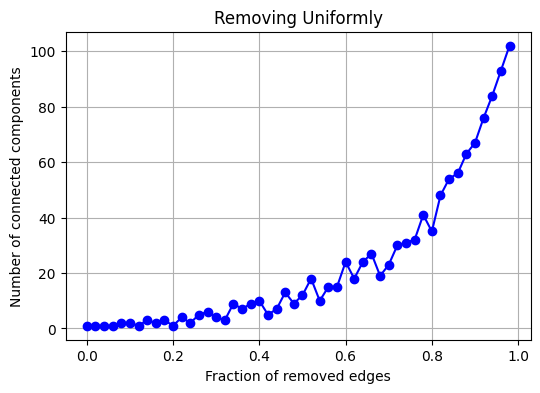

In [57]:
x = sorted(ncomponents_removing_uniformly_at_random_p.keys())
y = [ncomponents_removing_uniformly_at_random_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("Number of connected components")
plt.title("Removing Uniformly")
plt.grid(True)
plt.show()

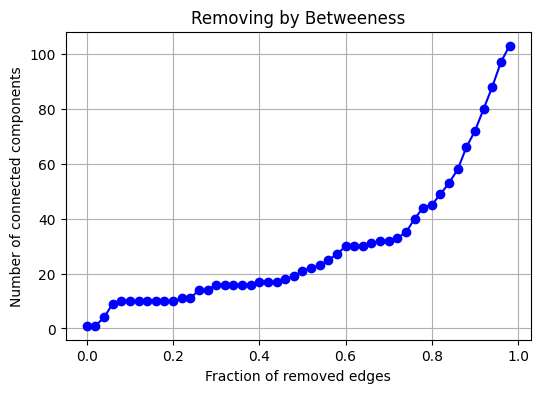

In [58]:
x = sorted(ncomponents_removing_by_betweenness_p.keys())
y = [ncomponents_removing_by_betweenness_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("Number of connected components")
plt.title("Removing by Betweeness")
plt.grid(True)
plt.show()

1. I cannot say I see a linear trend at all, It looks more exponential than anything. In the case of removing by betweeeness, it looks like it could be liner up until x = 0.75, but then it becomes exponential. For removing uniformly, it just looks to be exponential, at first little increase in number of connected components and it shoots up as we remove nearly all the edges.
2. With all edges removed, each node is its own cc so the fraction ccs/nodes is equal to 1.

If you run the code to calculate the number of connected components again, and plot the results, you will notice that the line corresponding to random removal is different every time. These fluctuations are, of course, a result of taking a random sample of edges to remove from the graph.

To obtain a better idea of the effect of random removal, we want to look at the *average* or *expected* number of connected components. We can do this by repeating the same experiment multiple times and computing the average number of components we obtain for a given fraction `p` over those experiments.

For the next task, do this by repeating the random removal experiment **50 times**, and plot the same graph as above but this time with the average. *Make sure to indicate that you are showing an an average in your plot.*

The code you write might take some time to run, but in most setups it should execute in *less than a minute*. If it's taking much longer, then probably the code is not correct. (It is absolutely possible to do this using pure Python, although if you know how to use `numpy` arrays you can make it faster!)

*Tip: reuse as much of your code as you can be wrapping it inside functions!*

---

Good practice for writing such loops:
- Try with fewer runs first, to make sure results are correct.
- Then increase the number of runs, and see if you get results within a reasonable amount of time.
- If not, iterate on the first steps, checking and editing the algorithm as needed.

---

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [59]:
n = 50

avg_ncomponents_removing_uniformly_at_random_p = {}
for p in fraction_values:
    sum_of_cc = 0
    for i in range(n):
        g_uniform = remove_edges_uniformly_at_random(g, p)
        sum_of_cc += count_connected_components(g_uniform)
    avg_ncomponents_removing_uniformly_at_random_p[p] = sum_of_cc // n

avg_ncomponents_removing_by_betweenness_p = {}
for p in fraction_values:
    sum_of_cc = 0
    for i in range(n):
        g_betweenness = remove_edges_by_betweenness(g, p)
        sum_of_cc += count_connected_components(g_betweenness)
    avg_ncomponents_removing_by_betweenness_p[p] = sum_of_cc // n

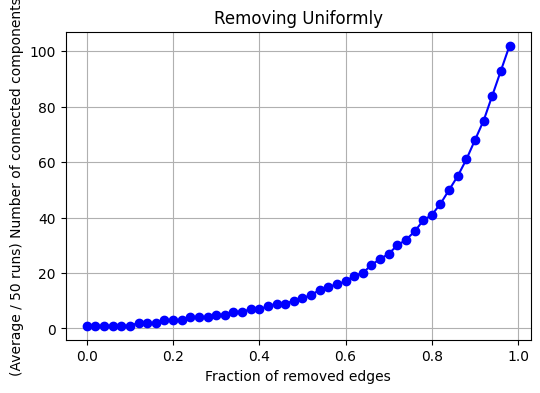

In [60]:
x = sorted(avg_ncomponents_removing_uniformly_at_random_p.keys())
y = [avg_ncomponents_removing_uniformly_at_random_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("(Average / 50 runs) Number of connected components")
plt.title("Removing Uniformly")
plt.grid(True)
plt.show()

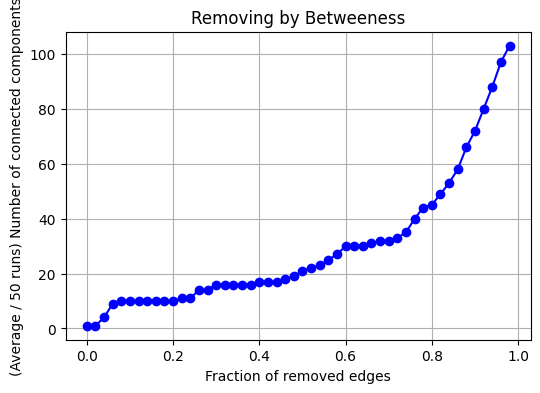

In [61]:
x = sorted(avg_ncomponents_removing_by_betweenness_p.keys())
y = [avg_ncomponents_removing_by_betweenness_p[p] for p in x]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.xlabel("Fraction of removed edges")
plt.ylabel("(Average / 50 runs) Number of connected components")
plt.title("Removing by Betweeness")
plt.grid(True)
plt.show()

Generally, they are both smoother than the graph that only did one trial per p, which makes sense. Its expecially noticeable in the graph of removing uniformly, which now looks like a clean exponential. In the case of the betweeeness-removal one, it seems that we are subject to the nature of the edge removing algorithm and the netowrk itself. Because we get this slightly choppy increase that then turns into an exponential shape. But overall smoother than the ones we had before for sure. Smooth enough to derive a mathematical relationship from, in the case of the uniform graph.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>